In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from collections import Counter
from xgboost import XGBRegressor
from sklearn import svm, metrics
from sklearn.pipeline import Pipeline
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import tensorflow as tf

# 데이터 불러오기
    - 기상 데이터
    - 위경도 데이터

In [2]:
# 데이터 불러오기
df_meta = pd.read_excel('META_관측지점정보_20210521134301.xlsx',header=1)
df_wea = pd.read_excel('combined_all_deltavg.xlsx')

In [3]:
# 위경도 데이터 전처리
df_meta = df_meta.rename(columns={"시작일": "일시"})

df_meta_uq = df_meta.drop_duplicates(['지점'],keep='last')[['지점','위도','경도','노장해발고도(m)','지점명']]
dict_meta = df_meta_uq.to_dict('records')

dict_meta_1 = dict()
for dic in dict_meta:
    dict_meta_1[dic['지점']] = [dic['위도'], dic['경도'], dic['노장해발고도(m)'], dic['지점명']]

# 데이터 전처리
    - 위도/경도/고도 매칭
    - 불필요한 데이터 제거

In [4]:
# 지점별로 위경도 매칭
df_wea['위도'] = df_wea['지점'].apply(lambda x: dict_meta_1[x][0])
df_wea['경도'] = df_wea['지점'].apply(lambda x: dict_meta_1[x][1])
df_wea['고도'] = df_wea['지점'].apply(lambda x: dict_meta_1[x][2])

# 불필요 데이터 제거
df_wea_null = df_wea.dropna(subset=['일 최심신적설(cm)'])
df_wea_null = df_wea_null.loc[df_wea_null['일 최심신적설(cm)']!=0]
df_wea_null['year'] = pd.to_datetime(df_wea_null['일시']).dt.year
df_wea_null = df_wea_null.sort_values(by=['지점명','일시'], ascending=True)
df_wea_null = df_wea_null.fillna(0)

# 모델링
    - 독립변수와 종속변수 저장
    - train 데이터와 test 데이터 생성
    - 모델별 교차 검증 진행

In [5]:
# 독립변수와 종속변수 저장
lst_place = df_wea_null['지점명'].unique()
col_y = '일 최심신적설(cm)'
col_x = list(set(df_wea_null.columns)-set([col_y]))

# train 데이터와 test 데이터 기간 생성
df_date_range = pd.Series(sorted(df_wea_null.year.unique()))
train_range = len(df_date_range)*0.8
df_date_range_train = df_date_range.loc[:train_range-1]
df_date_range_test = df_date_range.loc[train_range:]

# 성능 평가 지표를 계산하는 공식
def MAE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)))
def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))
def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def MPE(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100

# 모델 생성 및 파라미터 구성
model_rf = RandomForestRegressor()
model_svm = SVR()
model_xgb = XGBRegressor()
model_lr = LinearRegression()
# 튜닝할 파라미터 선택
lst_params_rf = {"bootstrap":[False], "n_estimators":[3, 10], "max_features":[4, 8],'max_depth' : [3,5,7]}
lst_params_svm = {'C': [1], 'gamma': [1]}
lst_params_xgb =  {'max_depth':[ 3,5,7],'n_estimators':[3, 10, 20]}
lst_params_lr = {}

model_list = [model_rf, model_xgb]#[model_rf , model_svm, model_xgb, model_lr]
model_param_list = [lst_params_rf, lst_params_svm, lst_params_xgb, lst_params_lr]

## 모델 별로 교차 검증으로 튜닝을 진행하고 성능 평가 진행

In [10]:
# 교차 검증을 위해 기간을 나누는 함수

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for idx, i in enumerate(range(0, len(lst), n)):
        print(idx, i, i+n)
        if idx == 4:
            yield lst[i:]
        elif idx == 5:
            pass
        else:
            yield lst[i:i + n]


# 데이터 기간 분리            
fold_data = list(chunks(df_date_range_train.values, 14))
# train 데이터 생성
df_train = df_wea_null.loc[df_wea_null['year'].isin(df_date_range_train.values)]


# 모델 별로 튜닝을 하며 교차검증을 진행
lst_total_result = []
lst_model_name = []
for model, params in zip(model_list, model_param_list):
    model_name = type(model).__name__
    lst_model_name.append(model_name)
    print(model_name)
    
    lst_fold_result = []
    lst_fold_name = []
    # 분리한 데이터 별로 튜닝을 하며 성능평가를 진행
    for idx, fold_valid in enumerate(fold_data):
        fold_name = 'fold_{}'.format(str(idx))
        print(fold_name)
        lst_col_learning = list(set(col_x) - set(['Unnamed: 0','일시','지점명','지점','year']))
        
        # 데이터 분리
        train = df_train.loc[~df_train['year'].isin(fold_valid)]
        test = df_train.loc[df_train['year'].isin(fold_valid)]
        X_train, y_train = train[lst_col_learning], train[col_y]
        X_test, y_test = test[lst_col_learning], test[col_y]
        # 모델 튜닝
        grid = GridSearchCV(model, params, cv=3, n_jobs = -1, scoring="neg_mean_squared_error")
        grid = grid.fit(X_train, y_train)
        print('The parameters combination that would give best accuracy is : ')
        print(grid.best_params_)
        # 모델 예측
        model = grid.best_estimator_
        model = model.fit(X_train, y_train)
        Y_test_pred = model.predict(X_test)
        # 성능 평가
        Test_mae = MAE(y_test, Y_test_pred)
        Test_mse = MSE(y_test, Y_test_pred)
        Test_rmse = RMSE(y_test, Y_test_pred)
        Test_mape = MAPE(y_test, Y_test_pred)
        Test_r2 = r2_score(y_test, Y_test_pred)
        # 결과 저장
        lst_fold_name.append(fold_name)
        lst_fold_result.append([Test_mae, Test_mse, Test_rmse, Test_mape, Test_r2])
    df_lst_fold_result = pd.DataFrame(lst_fold_result, index = lst_fold_name, columns=['mae','mse','rmse','mape','r2'])
    lst_mean_result = df_lst_fold_result.mean(axis=0).values
    
    lst_total_result.append(lst_mean_result)
    print('-'*100)
    print('-'*100)
# 최종 모델별 평균 성능 결과 저장
df_total_result = pd.DataFrame(lst_total_result, index = lst_model_name, columns=['mae','mse','rmse','mape','r2'])

0 0 14
1 14 28
2 28 42
3 42 56
4 56 70
5 70 84
RandomForestRegressor
fold_0


C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-13.53152204 -15.38980266          nan          nan -10.97180355
  -9.60096837          nan          nan  -8.80257807  -8.45412361
          nan          nan]
  warnings.warn(


The parameters combination that would give best accuracy is : 
{'bootstrap': False, 'max_depth': 7, 'max_features': 4, 'n_estimators': 10}
fold_1


C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-14.40687174 -12.30758247          nan          nan  -9.06671186
  -8.82435611          nan          nan  -9.21474809  -8.17989983
          nan          nan]
  warnings.warn(


The parameters combination that would give best accuracy is : 
{'bootstrap': False, 'max_depth': 7, 'max_features': 4, 'n_estimators': 10}
fold_2


C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-13.25290745 -13.65970228          nan          nan  -9.57422656
 -10.29323721          nan          nan  -9.17923957  -8.57102446
          nan          nan]
  warnings.warn(


The parameters combination that would give best accuracy is : 
{'bootstrap': False, 'max_depth': 7, 'max_features': 4, 'n_estimators': 10}
fold_3


C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-15.79334534 -16.57765388          nan          nan -11.56222574
 -10.01752329          nan          nan -10.31018993  -9.29153843
          nan          nan]
  warnings.warn(


The parameters combination that would give best accuracy is : 
{'bootstrap': False, 'max_depth': 7, 'max_features': 4, 'n_estimators': 10}
fold_4


C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-18.84408693 -14.94199509          nan          nan -14.58001256
 -11.39736496          nan          nan -11.66831297 -10.14143142
          nan          nan]
  warnings.warn(


The parameters combination that would give best accuracy is : 
{'bootstrap': False, 'max_depth': 7, 'max_features': 4, 'n_estimators': 10}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
XGBRegressor
fold_0
[17:35:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "C" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


The parameters combination that would give best accuracy is : 
{'C': 1, 'gamma': 1}
[17:35:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "C" } might not be used.

  This may not be accurate due t

## 모델별 예측 결과 비교

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
for model, params in zip(model_list, model_param_list):
    model_name = type(model).__name__
    lst_model_name.append(model_name)
    print(model_name)

    #fold_name = 'fold_{}'.format(str(idx))
    #print(fold_name)
    lst_col_learning = list(set(col_x) - set(['Unnamed: 0','일시','지점명','지점','year']))


    X_train, y_train = df_train[lst_col_learning], df_train[col_y]
    X_test, y_test = df_test[lst_col_learning], df_test[col_y]
    #grid = GridSearchCV(model, params, cv=3, n_jobs = -1, scoring="neg_mean_squared_error")
    #grid = grid.fit(X_train, y_train)
    #print('The parameters combination that would give best accuracy is : ')
    #print(grid.best_params_)
    #model = grid.best_estimator_
    model = model.fit(X_train, y_train)
    Y_test_pred = model.predict(X_test)

    plt.scatter(y_test, Y_test_pred, color='black', alpha=0.3)
    grid = list(range(80))
    plt.plot(grid,grid, color='gray', linewidth=0.7)
    plt.xlabel("실제 적설량")
    plt.ylabel("예측 적설량")
    plt.title("실제값 vs 예측값 비교 - {}".format(model_name))
    plt.savefig('실제값_예측값_비교_{}.png'.format(model_name))
    plt.grid(False)
    plt.show()

RandomForestRegressor


NameError: name 'df_test' is not defined

## 모델들 중 트리계열 모델의 변수 중요도 추출

Feature Importance of  XGBRegressor
최저기온(°C)                       importance: 0.1829
위도                             importance: 0.0000
평균 상대습도(%)                     importance: 0.0147
고도                             importance: 0.0000
경도                             importance: 0.0000
최고기온(°C)                       importance: 0.3459
일강수량(mm)                       importance: 0.4564


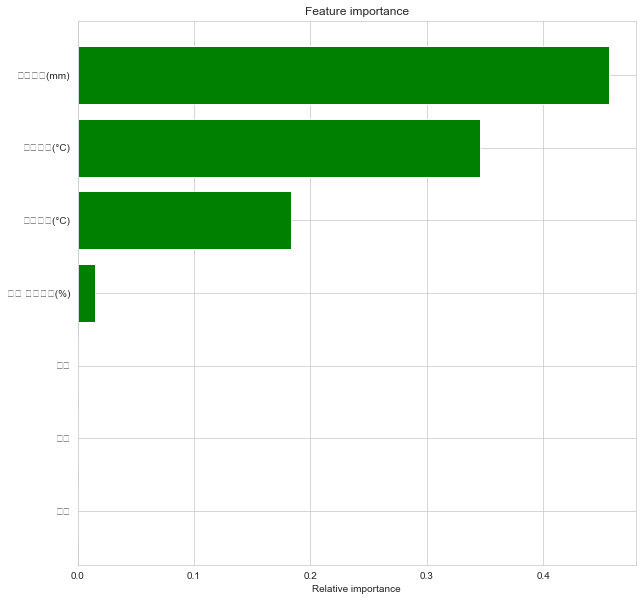

In [65]:
import matplotlib.pyplot as plt
import warnings
plt.rcParams['font.family'] = 'AppleGothic'
warnings.filterwarnings(action='ignore') 

sns.set_style('whitegrid')

feature_importance = model.feature_importances_
feature_importance_rel = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx_rel = np.argsort(feature_importance_rel)
ypos = np.arange(sorted_idx_rel.shape[0]) + .5

n=0
print("Feature Importance of ", model.__repr__().split('(')[0])
for index in feature_importance:   
    print ('{:30}'.format(X_train.columns[n]), 
           'importance: {:05.4f}'.format(index)
          )
    n = n+1

plt.figure(figsize=(10,10))
plt.barh(ypos, feature_importance[sorted_idx_rel], align='center', color = "Green")
plt.yticks(ypos, X_train.columns[sorted_idx_rel])
plt.xlabel('Relative importance')
plt.title('Feature importance')
plt.show()

## 모델링-lstm
    - 데이터 불러오기
    - 모델에 맞게 데이터 구조 변환
    - 모델 구축
    - 모델 튜닝
    - 성능 평가

In [ ]:
# 데이터 생성 및 구조 변환을 위한 함수

def load_data(data_all, look_back, lst_cols_x, cols_y):

    data_all = data_all[lst_cols_x+[cols_y]]       
    data_all = data_all.astype(np.float32)  
    return data_all

def create_dataset(dataset, look_back):

    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        data_x.append(a)
        data_y.append(dataset[i + look_back, -1])
    return np.array(data_x), np.array(data_y)

# 모델 생성 및 튜닝을 위한 함수

def model_lstm(x_train, y_train, x_val, y_val, params):

    # 모델 생성
    model = Sequential()
    model.add(LSTM(params['first_neuron'], 
                   dropout=params['dropout'],
                   activation='relu')
             )
    
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', metrics=['mae', 'mape'], optimizer=tf.keras.optimizers.Adam(lr=0.02))
    
    history = model.fit(x=x_train, 
                    y=y_train,
                    #validation_data=[x_val, y_val],
                    validation_split=0.1,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    verbose=0,
                    shuffle=False
                    )
    return history, model

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',
                                        min_value=2,
                                        max_value=6,
                                        step=2), 
                   dropout=0.5,
                   activation='relu')
             )
    
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))
    return model

params = {
    'first_neuron': [6, 12, 18, 24, 48],
    'dropout': [0.1, 0.2, 0.4],
    'batch_size': [8, 16, 32, 64, 128, 256],
    'epochs': [30, 40, 50, 60]
    }

## 모델을 튜닝한 후 교차 검증을 이용하여 모델의 성능 평가

In [60]:
lst_fold_result = []
lst_fold_name = []
for idx, fold_valid in enumerate(fold_data):
    fold_name = 'fold_{}'.format(str(idx))
    print(fold_name)
    lst_col_learning = list(set(col_x) - set(['Unnamed: 0','일시','지점명','지점','year']))

    train = df_train.loc[~df_train['year'].isin(fold_valid)]
    test = df_train.loc[df_train['year'].isin(fold_valid)]

    # split into train and test sets
    train = load_data(train, 3, lst_col_learning, col_y)
    test = load_data(test, 3, lst_col_learning, col_y)
    
    # reshape into X=t and Y=t+1
    train_x, train_y = create_dataset(train.values, 3)
    test_x, test_y = create_dataset(test.values, 3)
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], -1))
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], -1))    

    #tuner = RandomSearch(build_model,objective='val_accuracy',max_trials=1,executions_per_trial=1,directory='my_dir2',project_name='helloworld')
    #tuner.search(train_x, train_y,
    #             epochs=1,
    #             validation_data=(test_x, test_y))
    #models = tuner.get_best_models(num_models=1)
    #[i[0] for i in models[0].predict(test_x)]  
    #Y_test_pred, test_y = train_model(train_x, train_y, test_x, test_y, params, 1)
    model = Sequential()
    model.add(LSTM(48))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', metrics=['acc'], optimizer='adam')
    # make sure history object is returned by model.fit()
    history = model.fit(x=train_x, 
                    y=train_y,
                    validation_split=0.2,
                    epochs=10,
                    verbose=1,
                    shuffle=False
                    )
    Y_test_pred = model.predict(test_x)
    Y_test_pred = [i[0] for i in Y_test_pred]
    
    Test_mae = MAE(test_y, Y_test_pred)
    Test_mse = MSE(test_y, Y_test_pred)
    Test_rmse = RMSE(test_y, Y_test_pred)
    Test_mape = MAPE(test_y, Y_test_pred)
    Test_r2 = r2_score(test_y, Y_test_pred)

    lst_fold_name.append(fold_name)
    lst_fold_result.append([Test_mae, Test_mse, Test_rmse, Test_mape, Test_r2])
df_lst_fold_result = pd.DataFrame(lst_fold_result, index = lst_fold_name, columns=['mae','mse','rmse','mape','r2'])
lst_mean_result = df_lst_fold_result.mean(axis=0).values

df_total_result_lstm = pd.DataFrame(lst_mean_result, columns = ['lstm'], index=['mae','mse','rmse','mape','r2'])

fold_0
Epoch 1/10
806/806 [==============================] - 2s 3ms/step - loss: 42.9436 - acc: 0.0152 - val_loss: 15.5054 - val_acc: 0.0343
Epoch 2/10
806/806 [==============================] - 2s 2ms/step - loss: 35.9643 - acc: 0.0304 - val_loss: 13.7727 - val_acc: 0.0346
Epoch 3/10
806/806 [==============================] - 2s 2ms/step - loss: 33.2710 - acc: 0.0319 - val_loss: 14.0421 - val_acc: 0.0380
Epoch 4/10
806/806 [==============================] - 2s 2ms/step - loss: 32.9743 - acc: 0.0319 - val_loss: 14.0695 - val_acc: 0.0380
Epoch 5/10
806/806 [==============================] - 2s 2ms/step - loss: 33.0293 - acc: 0.0319 - val_loss: 14.0209 - val_acc: 0.0380
Epoch 6/10
806/806 [==============================] - 2s 2ms/step - loss: 32.9177 - acc: 0.0319 - val_loss: 13.8961 - val_acc: 0.0380
Epoch 7/10
806/806 [==============================] - 2s 2ms/step - loss: 32.8418 - acc: 0.0319 - val_loss: 13.8340 - val_acc: 0.0380
Epoch 8/10
806/806 [==============================] - 2

## 모델 테스트 데이터 예측 결과

Epoch 1/10
835/835 [==============================] - 2s 3ms/step - loss: 33.2807 - acc: 0.0324 - val_loss: 13.3702 - val_acc: 0.0390
Epoch 2/10
835/835 [==============================] - 2s 2ms/step - loss: 32.0984 - acc: 0.0326 - val_loss: 13.0977 - val_acc: 0.0390
Epoch 3/10
835/835 [==============================] - 2s 2ms/step - loss: 31.7185 - acc: 0.0326 - val_loss: 13.0334 - val_acc: 0.0390
Epoch 4/10
835/835 [==============================] - 2s 2ms/step - loss: 31.5446 - acc: 0.0326 - val_loss: 12.7612 - val_acc: 0.0390
Epoch 5/10
835/835 [==============================] - 2s 2ms/step - loss: 31.7157 - acc: 0.0326 - val_loss: 13.2086 - val_acc: 0.0390
Epoch 6/10
835/835 [==============================] - 2s 2ms/step - loss: 31.4161 - acc: 0.0326 - val_loss: 13.2853 - val_acc: 0.0390
Epoch 7/10
835/835 [==============================] - 2s 2ms/step - loss: 31.2986 - acc: 0.0326 - val_loss: 13.3734 - val_acc: 0.0390
Epoch 8/10
835/835 [==============================] - 2s 3ms/s

ValueError: x and y must be the same size

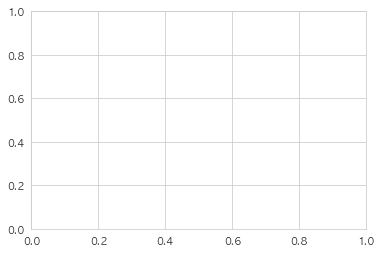

In [103]:
# split into train and test sets
train = load_data(df_train, 3, lst_col_learning, col_y)
test = load_data(df_test, 3, lst_col_learning, col_y)

# reshape into X=t and Y=t+1
train_x, train_y = create_dataset(train.values, 3)
test_x, test_y = create_dataset(test.values, 3)

train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], -1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], -1))    

#tuner = RandomSearch(build_model,objective='val_accuracy',max_trials=1,executions_per_trial=1,directory='my_dir2',project_name='helloworld')
#tuner.search(train_x, train_y,
#             epochs=1,
#             validation_data=(test_x, test_y))
#models = tuner.get_best_models(num_models=1)
#[i[0] for i in models[0].predict(test_x)]

# 모델 구축
model = Sequential()
model.add(LSTM(48))
model.add(Dense(1))
model.compile(loss='mean_squared_error', metrics=['acc'], optimizer='adam')
# 모델 학습
history = model.fit(x=train_x, 
                y=train_y,
                validation_split=0.2,
                epochs=10,
                verbose=1,
                shuffle=False
                )

# 모델 예측
Y_test_pred = model.predict(test_x)
Y_test_pred = [i[0] for i in Y_test_pred]

# 예측 결과 시각화
plt.scatter(y_test.values[4:], Y_test_pred, color='black', alpha=0.3)
grid = list(range(80))
plt.plot(grid,grid, color='gray', linewidth=0.7)
plt.xlabel("실제 적설량")
plt.ylabel("예측 적설량")
plt.title("실제값 vs 예측값 비교 - {}".format('lstm'))
plt.savefig('실제값_예측값_비교_{}.png'.format('lstm'))
plt.grid(False)
plt.show()

# 테스트 데이터 예측 및 결과

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams['font.family'] = 'AppleGothic'
warnings.filterwarnings(action='ignore') 

# 트레인 데이터 생성
df_date_range = pd.Series(sorted(df_wea_null.year.unique()))
train_range = len(df_date_range)*0.8
df_date_range_train = df_date_range.loc[:train_range-1]
df_date_range_test = df_date_range.loc[train_range:]
df_test = df_wea_null.loc[df_wea_null['year'].isin(df_date_range_test.values)]

# 예측 및 결과 저장
X_test, y_test = df_test[lst_col_learning], df_test[col_y]
Y_test_pred = model.predict(X_test)
df_test['예측적설량'] = Y_test_pred
df_test['year_month'] = df_test['일시'].astype(str).apply(lambda x: x[:7])

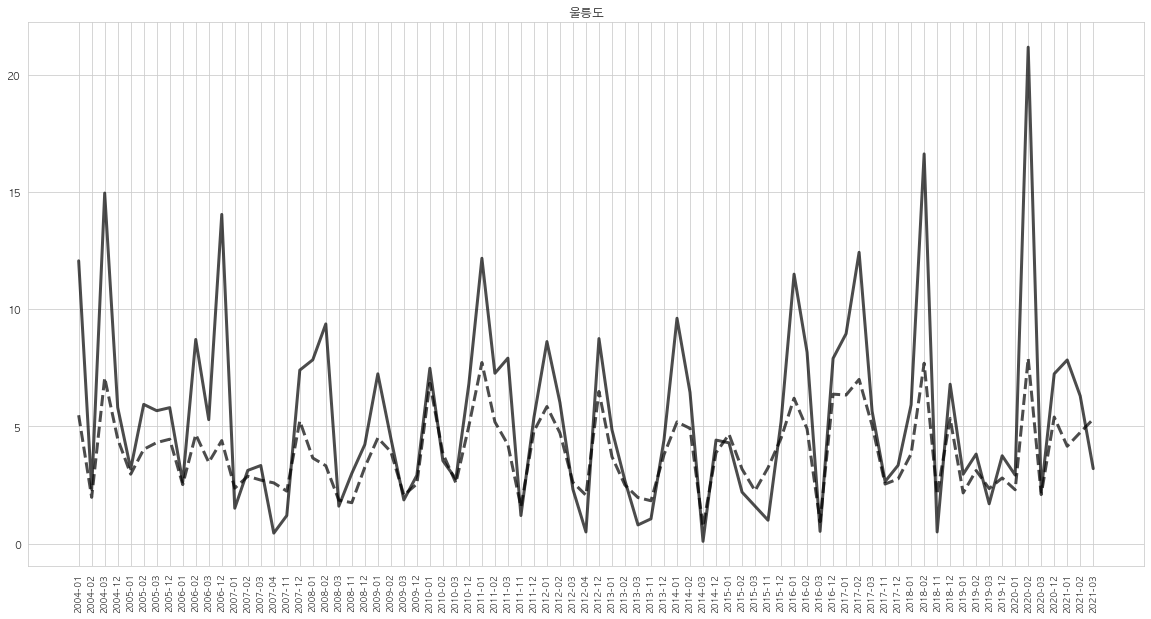

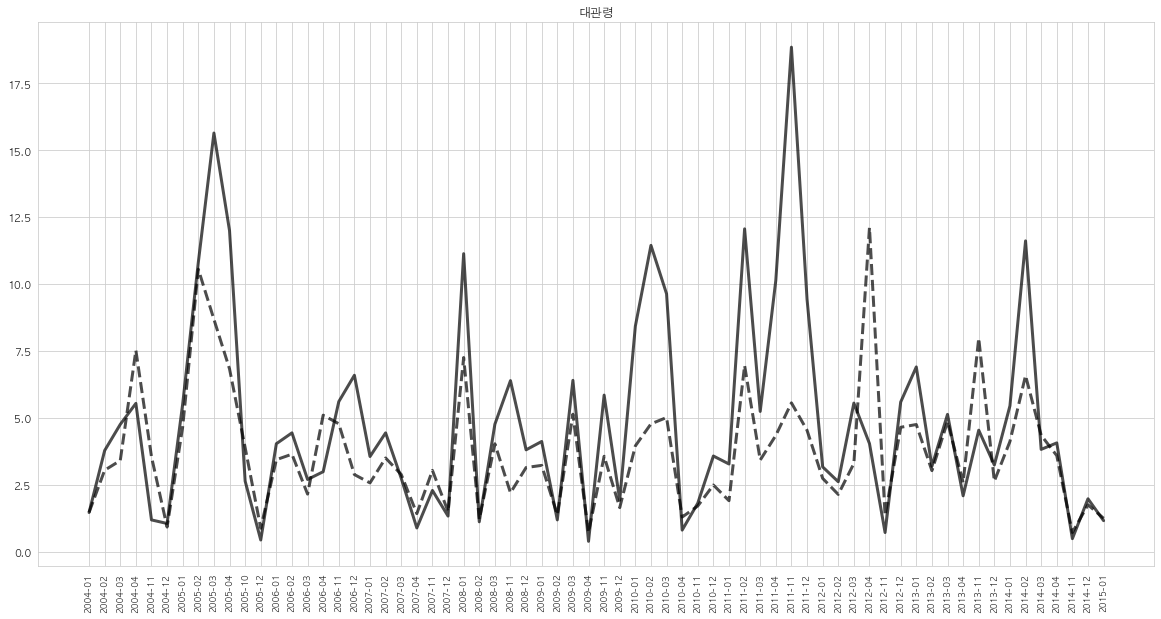

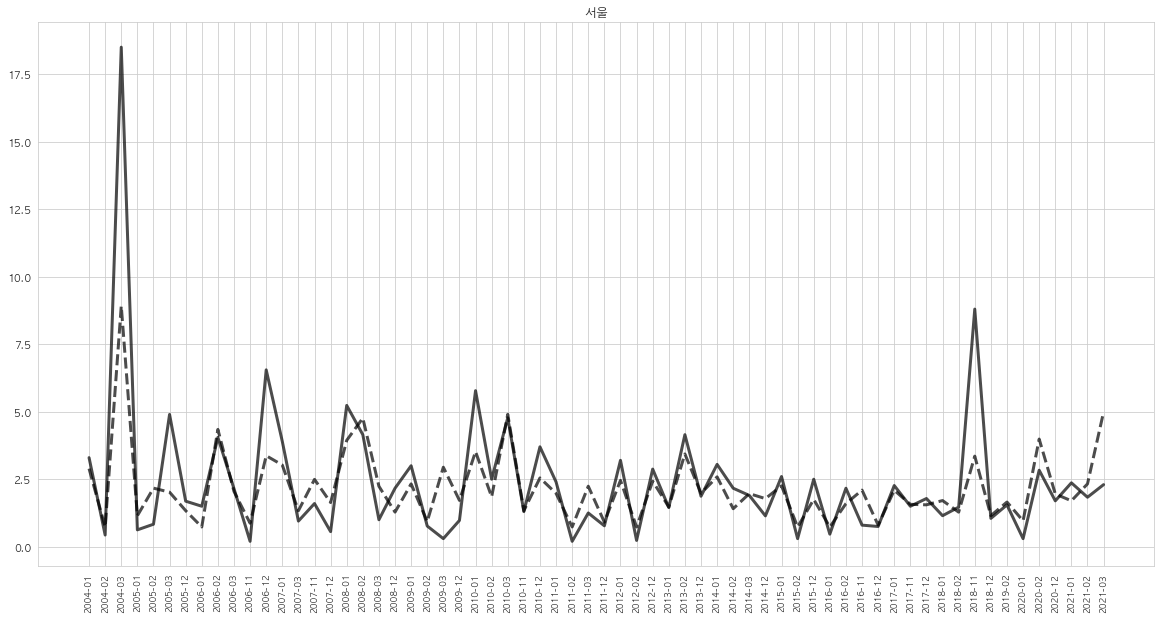

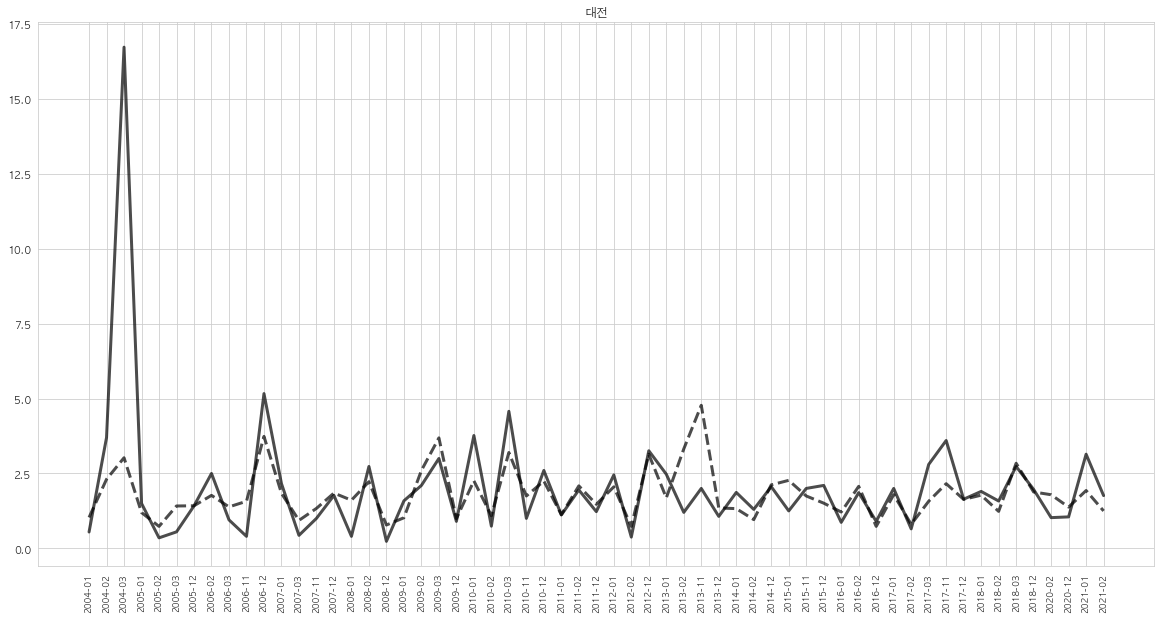

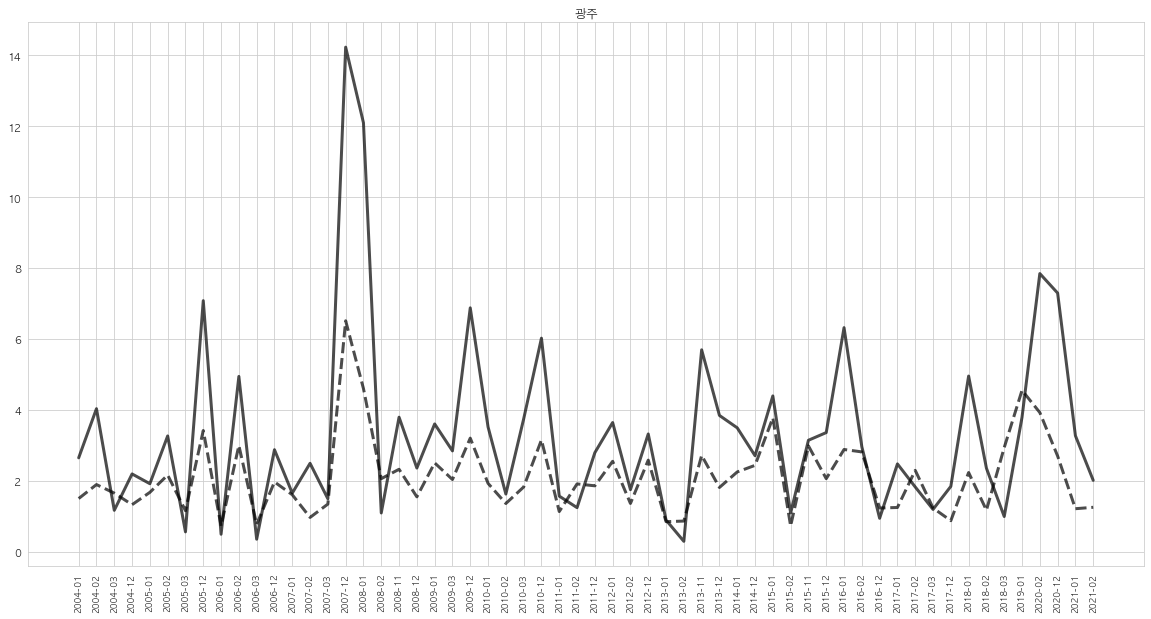

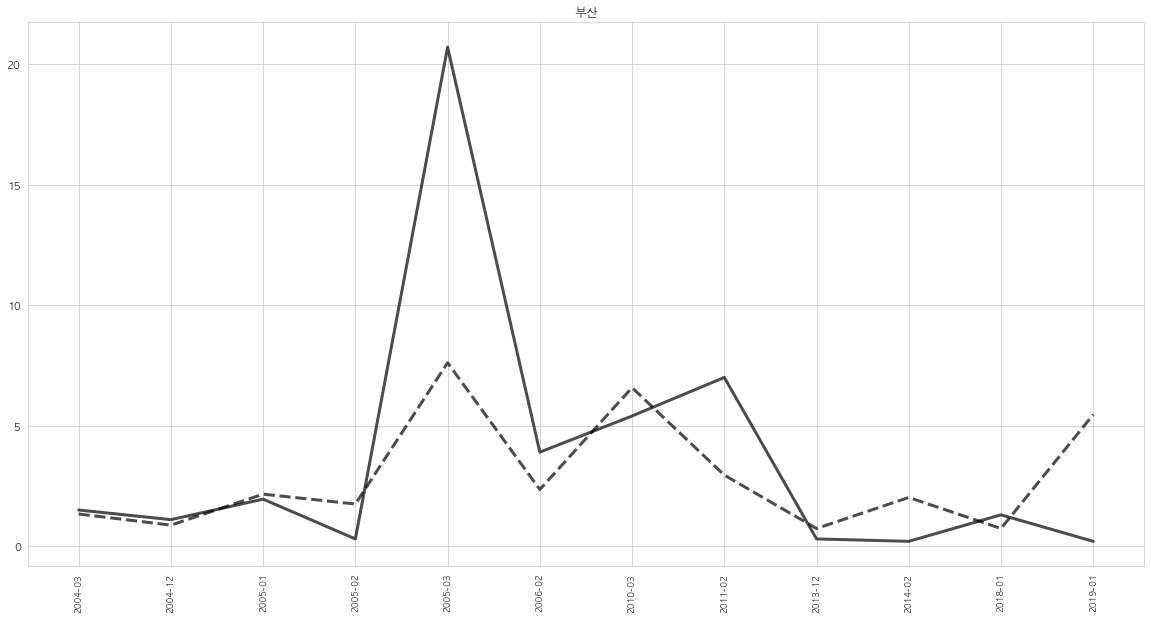

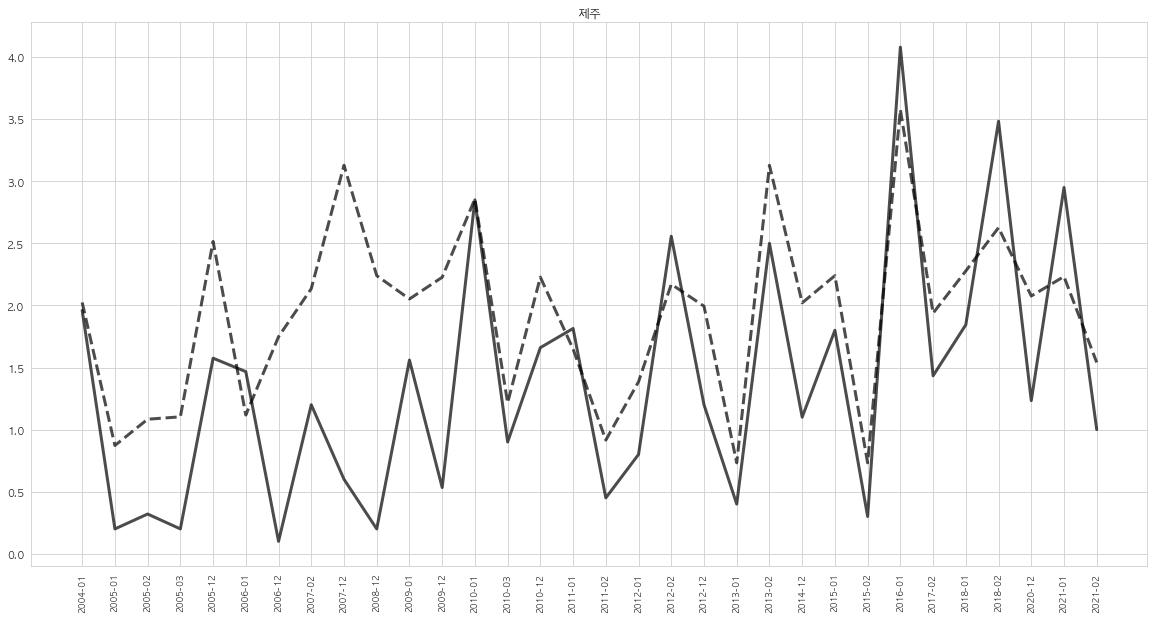

In [80]:
# 지점별 모델 예측 결과 시각화
lst_place = ['울릉도','대관령','서울','대전','광주','부산','제주']
for place in lst_place:
    df_plot = df_test.loc[df_test['지점명']==place].groupby('year_month')[['일 최심신적설(cm)','예측적설량']].agg('mean')
    
    fig, ax = plt.subplots(figsize=(20,10))
    x_grid = list(range(len(df_plot)))
    ax.plot(x_grid, df_plot['예측적설량'].values, color='black', linewidth=3, alpha=0.7, linestyle = '--')
    ax.plot(x_grid, df_plot['일 최심신적설(cm)'].values, color='black', linewidth=3, alpha=0.7)
    plt.title(place)
    plt.grid(True, axis='both')

    plt.xticks(x_grid, df_plot.index, size='small', rotation=90)
    plt.savefig('savefig_{}.png'.format(place))
    plt.show()

# RCP 기후 시나리오를 이용한 예측

In [ ]:
# 시나리오별 연도 폴더 생성
import os

for rcp_num in ['rcp26','rcp45','rcp60','rcp85']:
    path = "D:/대설예측 관련 데이터/RCP시나리오/시나리오/{}/".format(rcp_num)
    for date in [str(i+2000) for i in list(range(21,101,1))]:
        os.makedirs(path + date)

In [28]:
def preproc_rcpdata(df_total_rcp):

    df_total_rcp['year'] = df_total_rcp['일시'].astype('str').str.slice(start=0, stop=4)
    df_total_rcp['month'] = df_total_rcp['일시'].astype('str').str.slice(start=4, stop=6)

    rcp_range_year = [str(i+2000) for i in list(range(21,101,1))]
    rcp_range_month = ['10','11','12','01','02','03','04']
    df_total_rcp = df_total_rcp.loc[(df_total_rcp['year'].isin(rcp_range_year)) & (df_total_rcp['month'].isin(rcp_range_month))]
    df_total_rcp.drop(['year','month','index'],axis=1,inplace=True)
    return df_total_rcp

for rcp_num in ['rcp26','rcp45','rcp60','rcp85']:

    df_rain = pd.read_csv('C:/Users/admin/mok/km_snowfall_project/RCP시나리오/rcp_강수량_{}.csv'.format(rcp_num))
    df_humid = pd.read_csv('C:/Users/admin/mok/km_snowfall_project/RCP시나리오/rcp_상대습도_{}.csv'.format(rcp_num))
    df_tempmax = pd.read_csv('C:/Users/admin/mok/km_snowfall_project/RCP시나리오/rcp_최고기온_{}.csv'.format(rcp_num))
    df_tempmin = pd.read_csv('C:/Users/admin/mok/km_snowfall_project/RCP시나리오/rcp_최저기온_{}.csv'.format(rcp_num))

    df_rain.columns = ['index','일시','지점','일강수량(mm)']
    df_humid.columns = ['index','일시','지점','평균 상대습도(%)']
    df_tempmax.columns = ['index','일시','지점','최고기온(°C)']
    df_tempmin.columns = ['index','일시','지점','최저기온(°C)']

    df_rain = preproc_rcpdata(df_rain)
    df_humid = preproc_rcpdata(df_humid)
    df_tempmax = preproc_rcpdata(df_tempmax)
    df_tempmin = preproc_rcpdata(df_tempmin)
    
    df_rcp = pd.merge(df_rain, df_tempmax, on=['일시', '지점'], how='inner')
    df_rcp = pd.merge(df_rcp, df_tempmin, on=['일시', '지점'], how='inner')
    df_rcp = pd.merge(df_rcp, df_humid, on=['일시', '지점'], how='left')

    df_rcp = df_rcp.replace(-99,0)
    df_rcp = df_rcp.fillna(0)

    df_rcp['위도'] = df_rcp['지점'].apply(lambda x: dict_meta_1[x][0])
    df_rcp['경도'] = df_rcp['지점'].apply(lambda x: dict_meta_1[x][1])
    df_rcp['고도'] = df_rcp['지점'].apply(lambda x: dict_meta_1[x][2])
    df_rcp['지점명'] = df_rcp['지점'].apply(lambda x: dict_meta_1[x][3])

    Y_test_pred = model.predict(df_rcp[lst_col_learning])
    df_rcp['예측적설량'] = Y_test_pred
    df_rcp.loc[df_rcp['예측적설량'] < 0,'예측적설량'] = 0
    df_rcp.columns=['date','No','rain','temp_max','temp_min','humid','Lat','Long','height','Name','SnowDepth']
    df_final = df_rcp[['date','No','Name','Lat','Long','SnowDepth']]

    for date in sorted(df_final.date.unique()):
        print(year)
        year = str(date)[:4]
        path_dir = 'C:/Users/admin/mok/km_snowfall_project/시나리오/{}/{}/'.format(rcp_num,year)
        name_file = '{}_sn_{}.csv'.format(rcp_num,str(date))
        path_save = path_dir+name_file
        df_data= df_final.loc[df_final['date']==date].reset_index(drop=True)
        df_data.to_csv(path_save, index=False, encoding='cp949')

2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021


2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029


2036
2036
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037
2037


2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045
2045


2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053


2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061
2061


2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069
2069


2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077
2077


2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085
2085


2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093
2093


2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021


2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029
2029


2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036


2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044


2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052
2052


2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060
2060


2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068
2068


2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076
2076


2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084
2084


2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092
2092


2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100
2100


2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028


2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036
2036


2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044
2044


2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051


2058
2058
2058
2058
2058
2058
2058
2058
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059
2059


2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067
2067


2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075
2075


2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083
2083


2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091
2091


2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099
2099


2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2026
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027
2027


2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2034
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035
2035


2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043
2043


2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051
2051


2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2058
2059
2059


2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2065
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066
2066


2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2073
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074
2074


2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2081
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082
2082


2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2089
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090
2090


2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2097
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098
2098


In [18]:
df_rain = pd.read_csv('C:/Users/admin/mok/km_snowfall_project/RCP시나리오/rcp_강수량_{}.csv'.format('rcp26'))

In [22]:
df_rain.columns = ['index','일시','지점','일강수량(mm)']

In [24]:
df_rain['year'] = df_rain['일시'].astype('str').str.slice(start=0, stop=4)
df_rain['month'] = df_rain['일시'].astype('str').str.slice(start=4, stop=6)

In [25]:
df_rain

index        일시   지점  일강수량(mm)  year month
0            0  20211013   90     -99.0  2021    10
1            1  20211013   93     -99.0  2021    10
2            2  20211013   95     -99.0  2021    10
3            3  20211013   98     -99.0  2021    10
4            4  20211013   99     -99.0  2021    10
...        ...       ...  ...       ...   ...   ...
1748832     98  21000131  285       0.6  2100    01
1748833     99  21000131  288       0.3  2100    01
1748834    100  21000131  289       1.2  2100    01
1748835    101  21000131  294     -99.0  2100    01
1748836    102  21000131  295     -99.0  2100    01

[1748837 rows x 6 columns]

In [26]:
df_rain.month.unique()

array(['10', '11', '03', '01', '02', '04', '12'], dtype=object)

In [21]:
[str(i+2000) for i in list(range(21,101,1))]

['2021',
 '2022',
 '2023',
 '2024',
 '2025',
 '2026',
 '2027',
 '2028',
 '2029',
 '2030',
 '2031',
 '2032',
 '2033',
 '2034',
 '2035',
 '2036',
 '2037',
 '2038',
 '2039',
 '2040',
 '2041',
 '2042',
 '2043',
 '2044',
 '2045',
 '2046',
 '2047',
 '2048',
 '2049',
 '2050',
 '2051',
 '2052',
 '2053',
 '2054',
 '2055',
 '2056',
 '2057',
 '2058',
 '2059',
 '2060',
 '2061',
 '2062',
 '2063',
 '2064',
 '2065',
 '2066',
 '2067',
 '2068',
 '2069',
 '2070',
 '2071',
 '2072',
 '2073',
 '2074',
 '2075',
 '2076',
 '2077',
 '2078',
 '2079',
 '2080',
 '2081',
 '2082',
 '2083',
 '2084',
 '2085',
 '2086',
 '2087',
 '2088',
 '2089',
 '2090',
 '2091',
 '2092',
 '2093',
 '2094',
 '2095',
 '2096',
 '2097',
 '2098',
 '2099',
 '2100']